In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
import os
import pandas as pd 
from ipyleaflet import GeoJSON, Marker, MarkerCluster

In [3]:
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [4]:
caohu = ee.FeatureCollection('users/311605001111/caohu_region')
Map.addLayer(caohu, {}, "caohu_vector")
Map.centerObject(caohu,10)   # 设置以研究区居中

In [5]:
# 输入研究区的shp文件所在路径
monitor_point = "D:/NDVI_exercise/caohu/monitor_point.shp"
# shp 转 ee
monitor_point_ee = geemap.shp_to_ee(monitor_point)
# 添加到layer
Map.addLayer(monitor_point_ee, {}, "monitor_point")

In [6]:
# images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
#     .filterBounds(caohu) \
#     .filterDate('2016-01-01', '2016-01-31') \
#     .sort('CLOUD_COVER')

# best_image = images.first()

# print(best_image.get('system:id').getInfo())
# print(best_image.get('CLOUD_COVER').getInfo())

In [7]:
caohu = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_121038_20160115').clip(caohu)
vis_params = {
  'bands': ['B5', 'B4', 'B3'],
  'min': 0,
  'max': 6000,
  'gamma': 1.4,
}

caohu_image = caohu.addBands(caohu.select('B5').divide(caohu.select('B4')).rename('B5_B4'))

Map.addLayer(caohu_image, vis_params, 'caohu_image')

In [ ]:
# # 添加数据文件所在目录的路径，idex_col指索引列
# df = pd.read_csv('D:/NDVI_exercise/caohu_chla.csv',index_col='id')

# maker_cluster = MarkerCluster(
#     markers=[Marker(location=[df.iloc[i,3],df.iloc[i,2]]) for i in range(0,19)],
#     name = 'Markers')
# Map.add_layer(maker_cluster)

In [8]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
csv = os.path.join(out_dir, 'monitor_point.csv')

geemap.extract_values_to_points(monitor_point_ee,caohu_image,csv)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\DELL\Downloads\monitor_point.csv


##  根据系数，建立模型，反演水质参数

In [ ]:
def chla_inversion(image,a,b):
    evi = image.expression('a*(B5/B4)+b',
        {
          'B5/B4': image.select('B5/B4')
        }).rename('CHLA')

In [ ]:
# 将a,b更换了线性回归的数字
caohu_chla = caohu_image.expression('a*(B5_B4)+b',{'a': 0.1747,'b': -0.0149,'B5_B4': caohu_image.select('B5_B4')})

Map.addLayer(caohu_chla,{}, 'caohu_chla')

## 一元线性回归

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [10]:
one_regression = pd.read_csv('C:/Users/DELL/Downloads/monitor_point.csv',index_col='id')

[0.4154  0.0685  0.05167 0.09096 0.0325  0.0685  0.07507 0.07084 0.05845
 0.02361 0.06173 0.03135 0.61604 0.26429 0.03018 0.03579 0.06831 0.07412
 0.03251]
[1.4812593  1.0804597  0.3628692  0.43141592 0.3707415  0.3846939
 0.44309393 0.41920903 0.4017094  0.4642409  0.36556855 0.37192982
 0.4688562  0.37372592 0.33920705 0.32662192 0.4939759  0.36293858
 0.3523316 ]


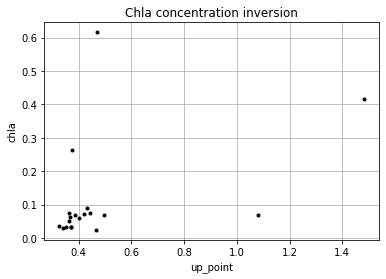

In [11]:
# 提取表格中相应列的值
chla = one_regression.loc[:,'chla'].values #叶绿素浓度
up_point = one_regression.loc[:,'B5_B4'].values #像元值

# 输出提取的数值
print(chla)
print(up_point)

# 定义绘图的样式
def runplt():
    plt.figure()
    plt.title("Chla concentration inversion")
    plt.xlabel('up_point')
    plt.ylabel('chla')
    plt.grid(True)
    return plt

# 根据提取的数字，绘图。x轴为up_point,y轴为chla
plt = runplt()
plt.plot(up_point, chla, 'k.')
plt.show()

[0.04997632 0.09439137]


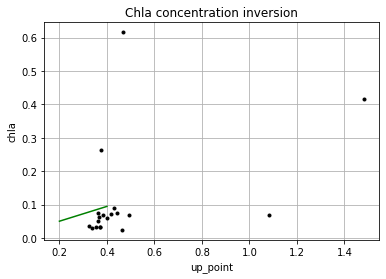

In [14]:
chla = one_regression.loc[:,'chla'].values #叶绿素浓度
up_point = one_regression.loc[:,'B5_B4'].values #像元值
# 拟合曲线
model = LinearRegression()  # 创建模型
x = up_point.reshape((-1,1))
y = chla
model.fit(x, y)  # 拟合

# 进行预测
X2 = [[0.2], [0.4]] # 取两个预测值
y2 = model.predict(X2)  # 进行预测
print(y2)  # 查看预测值

plt = runplt()
plt.plot(up_point, chla, 'k.')
plt.plot(X2, y2, 'g-')  # 画出拟合曲线
plt.show()

In [12]:
# 计算一元线性方程的系数，y = wx + b
variance = np.var(up_point, ddof=1)  # 计算方差，doff为贝塞尔（无偏估计）校正系数
covariance = np.cov(up_point, chla)[0][1]  # 计算协方差
w = covariance / variance
b = np.mean(chla) - w * np.mean(up_point)

print("w = %f\nb = %f" % (w, b))

w = 0.222075
b = 0.005561


In [16]:
# 计算均方误差
X = up_point.reshape((-1,1))
y = chla.reshape((-1,1))
print("均方误差为: %f" % np.mean((model.predict(X)-y) ** 2))

均方误差为: 0.026488
